In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.models import save_model, load_model
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from math import floor


# Keeping this as a reference for how we created the data
#train1 = pd.read_csv('train_1.csv', sep=',', header=0)
#train2 = pd.read_csv('train_2.csv', sep=',', header=0)
#train3 = pd.read_csv('train_3.csv', sep=',', header=0)
#train4 = pd.read_csv('train_4.csv', sep=',', header=0)
#train = pd.concat([train1, train2, train3, train4], ignore_index=True)
#test = pd.read_csv('test.csv', header=0)
#train = train[train['store_nbr'] == 1]
#train = train.drop(columns=["id", "store_nbr"], axis=1)
#train_data = train.pivot_table(index=['date'], columns="family", values='sales')
#train_data["total_sales"] = train_data[list(train_data.columns[1:])].sum(axis=1)
#amt = floor(len(train_data)*.8)
#test_data = train_data[amt:]
#train_data = train_data[:amt]



In [2]:
def parse_data(column_index, scaler):

    store_1_data = pd.read_csv("train_data_store_1.csv")
    if column_index == (len(store_1_data.columns)-1):
        total_sales = store_1_data.iloc[:,-1:].values
    else:
        total_sales = store_1_data.iloc[:, column_index: (column_index+1 if (column_index+1) <= (len(store_1_data.columns) - 1) else -1) ].values
 
    training_set = total_sales[:floor(len(total_sales)*.8)]
    testing_set = total_sales[floor(len(total_sales)*.8):]
    scaled_data = scaler.fit_transform(training_set)
    X_train = []
    y_train = []
    for i in range(14, len(training_set)):
        X_train.append(scaled_data[i-14:i, 0])
        y_train.append(scaled_data[i, 0])
    X_train, y_train = np.array(X_train), np.array(y_train)
    X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
    return X_train, y_train, total_sales, training_set, testing_set
def create_model(X_train):
    model = Sequential()
    model.add(LSTM(units=55, return_sequences=True, input_shape=(X_train.shape[1], 1)))
    model.add(Dropout(0.2))
    model.add(LSTM(units=55, return_sequences=True))
    model.add(Dropout(0.2))
    model.add(LSTM(units=55, return_sequences=True))
    model.add(LSTM(units=55))
    model.add(Dropout(0.2))
    model.add(Dense(units=1))
    model.compile(optimizer='adam', loss='mean_squared_logarithmic_error')
    return model







In [3]:

def train_fit_predict(column_index, epochs, batch_size):
    scaler = MinMaxScaler(feature_range=(0,1))
    X_train, y_train, column_data, training_set, testing_set = parse_data(column_index, scaler)
    model = create_model(X_train)
    model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size)
    total_sales = column_data
    data = pd.DataFrame(total_sales[len(total_sales) - len(testing_set) - 14:]).values
    data = data.reshape(-1, 1)
    data = scaler.transform(data)
    X_test = []
    for i in range(14, len(testing_set)):
        X_test.append(data[i-14:i, 0])
    X_test = np.array(X_test)
    X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
    pred = model.predict(X_test)
    pred = scaler.inverse_transform(pred)
    return pred, testing_set

In [4]:
#Save model
#model.save('austin_model_save')

In [5]:
#Load model
#model = load_model('austin_model_save')

In [6]:
def predict_column(column_index_to_test, epochs, batch_size):
    pred, testing_set = train_fit_predict(column_index_to_test, epochs, batch_size)
    colNames = pd.read_csv("train_data_store_1.csv").columns
    plt.plot(testing_set[:-14], color='blue', label=f'{colNames[column_index_to_test]} Sales')
    plt.plot(pred, color='red', label=f'{colNames[column_index_to_test]} Predicted Total Sales')
    plt.title(f"Store 1 {colNames[column_index_to_test].title()} sales")
    plt.legend()

Epoch 1/100
42/42 [==============================] - 6s 14ms/step - loss: 0.0157
Epoch 2/100
42/42 [==============================] - 1s 14ms/step - loss: 0.0140
Epoch 3/100
42/42 [==============================] - 1s 14ms/step - loss: 0.0138
Epoch 4/100
42/42 [==============================] - 1s 14ms/step - loss: 0.0140
Epoch 5/100
42/42 [==============================] - 1s 14ms/step - loss: 0.0139
Epoch 6/100
42/42 [==============================] - 1s 14ms/step - loss: 0.0139
Epoch 7/100
42/42 [==============================] - 1s 13ms/step - loss: 0.0139
Epoch 8/100
42/42 [==============================] - 1s 13ms/step - loss: 0.0140
Epoch 9/100
42/42 [==============================] - 1s 13ms/step - loss: 0.0140
Epoch 10/100
42/42 [==============================] - 1s 14ms/step - loss: 0.0143
Epoch 11/100
42/42 [==============================] - 1s 14ms/step - loss: 0.0140
Epoch 12/100
42/42 [==============================] - 1s 14ms/step - loss: 0.0138
Epoch 13/100
42/42 [=====

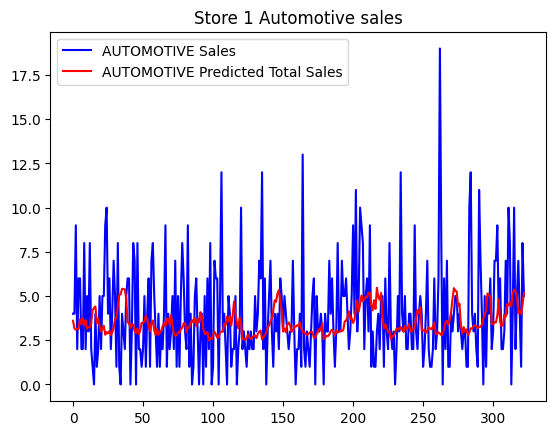

In [7]:
predict_column(1, 100, 32)

Epoch 1/100
42/42 [==============================] - 6s 15ms/step - loss: 0.0000e+00
Epoch 2/100
42/42 [==============================] - 1s 15ms/step - loss: 0.0000e+00
Epoch 3/100
42/42 [==============================] - 1s 15ms/step - loss: 0.0000e+00
Epoch 4/100
42/42 [==============================] - 1s 14ms/step - loss: 0.0000e+00
Epoch 5/100
42/42 [==============================] - 1s 14ms/step - loss: 0.0000e+00
Epoch 6/100
42/42 [==============================] - 1s 14ms/step - loss: 0.0000e+00
Epoch 7/100
42/42 [==============================] - 1s 14ms/step - loss: 0.0000e+00
Epoch 8/100
42/42 [==============================] - 1s 14ms/step - loss: 0.0000e+00
Epoch 9/100
42/42 [==============================] - 1s 14ms/step - loss: 0.0000e+00
Epoch 10/100
42/42 [==============================] - 1s 14ms/step - loss: 0.0000e+00
Epoch 11/100
42/42 [==============================] - 1s 14ms/step - loss: 0.0000e+00
Epoch 12/100
42/42 [==============================] - 1s 14ms/s

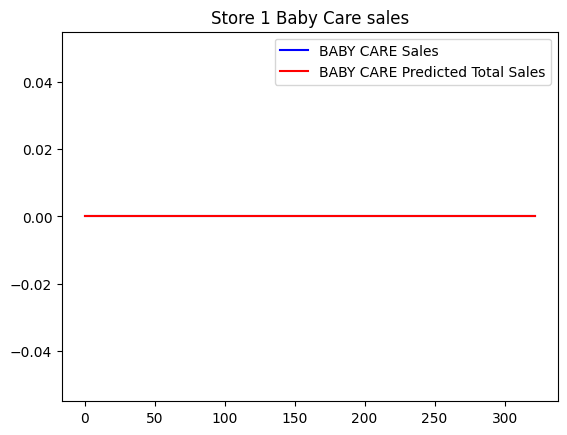

In [8]:
predict_column(2, 100, 32)

Epoch 1/100
42/42 [==============================] - 6s 14ms/step - loss: 0.0393
Epoch 2/100
42/42 [==============================] - 1s 14ms/step - loss: 0.0393
Epoch 3/100
42/42 [==============================] - 1s 14ms/step - loss: 0.0393
Epoch 4/100
42/42 [==============================] - 1s 14ms/step - loss: 0.0393
Epoch 5/100
42/42 [==============================] - 1s 14ms/step - loss: 0.0393
Epoch 6/100
42/42 [==============================] - 1s 14ms/step - loss: 0.0393
Epoch 7/100
42/42 [==============================] - 1s 14ms/step - loss: 0.0393
Epoch 8/100
42/42 [==============================] - 1s 14ms/step - loss: 0.0393
Epoch 9/100
42/42 [==============================] - 1s 14ms/step - loss: 0.0393
Epoch 10/100
42/42 [==============================] - 1s 14ms/step - loss: 0.0393
Epoch 11/100
42/42 [==============================] - 1s 14ms/step - loss: 0.0393
Epoch 12/100
42/42 [==============================] - 1s 14ms/step - loss: 0.0393
Epoch 13/100
42/42 [=====

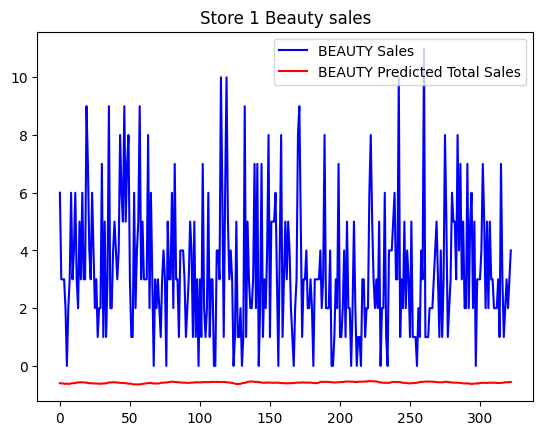

In [9]:
predict_column(3, 100, 32)

Epoch 1/100
42/42 [==============================] - 6s 17ms/step - loss: 0.0118
Epoch 2/100
42/42 [==============================] - 1s 17ms/step - loss: 0.0062
Epoch 3/100
42/42 [==============================] - 1s 17ms/step - loss: 0.0058
Epoch 4/100
42/42 [==============================] - 1s 17ms/step - loss: 0.0059
Epoch 5/100
42/42 [==============================] - 1s 17ms/step - loss: 0.0061
Epoch 6/100
42/42 [==============================] - 1s 17ms/step - loss: 0.0056
Epoch 7/100
42/42 [==============================] - 1s 17ms/step - loss: 0.0056
Epoch 8/100
42/42 [==============================] - 1s 17ms/step - loss: 0.0058
Epoch 9/100
42/42 [==============================] - 1s 17ms/step - loss: 0.0056
Epoch 10/100
42/42 [==============================] - 1s 17ms/step - loss: 0.0056
Epoch 11/100
42/42 [==============================] - 1s 17ms/step - loss: 0.0055
Epoch 12/100
42/42 [==============================] - 1s 17ms/step - loss: 0.0057
Epoch 13/100
42/42 [=====

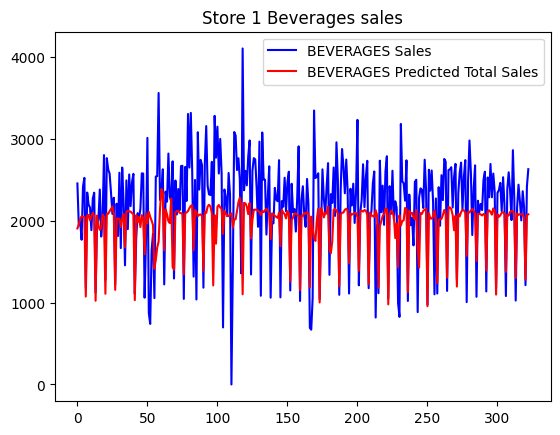

In [10]:
predict_column(4, 100, 32)

Epoch 1/100
42/42 [==============================] - 5s 14ms/step - loss: 0.0000e+00
Epoch 2/100
42/42 [==============================] - 1s 15ms/step - loss: 0.0000e+00
Epoch 3/100
42/42 [==============================] - 1s 15ms/step - loss: 0.0000e+00
Epoch 4/100
42/42 [==============================] - 1s 15ms/step - loss: 0.0000e+00
Epoch 5/100
42/42 [==============================] - 1s 15ms/step - loss: 0.0000e+00
Epoch 6/100
42/42 [==============================] - 1s 15ms/step - loss: 0.0000e+00
Epoch 7/100
42/42 [==============================] - 1s 15ms/step - loss: 0.0000e+00
Epoch 8/100
42/42 [==============================] - 1s 14ms/step - loss: 0.0000e+00
Epoch 9/100
42/42 [==============================] - 1s 14ms/step - loss: 0.0000e+00
Epoch 10/100
42/42 [==============================] - 1s 14ms/step - loss: 0.0000e+00
Epoch 11/100
42/42 [==============================] - 1s 15ms/step - loss: 0.0000e+00
Epoch 12/100
42/42 [==============================] - 1s 14ms/s

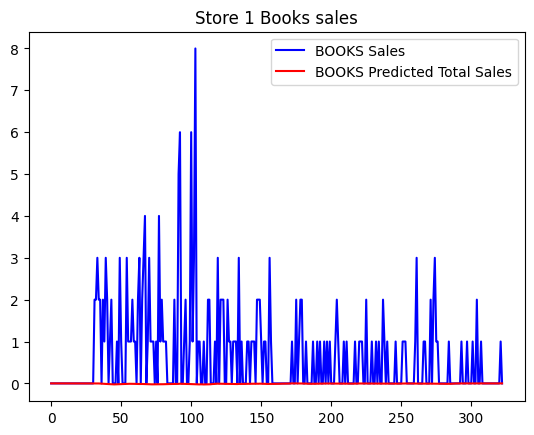

In [11]:
predict_column(5, 100, 32)

Epoch 1/100
42/42 [==============================] - 6s 18ms/step - loss: 0.0315
Epoch 2/100
42/42 [==============================] - 1s 18ms/step - loss: 0.0137
Epoch 3/100
42/42 [==============================] - 1s 18ms/step - loss: 0.0137
Epoch 4/100
42/42 [==============================] - 1s 18ms/step - loss: 0.0131
Epoch 5/100
42/42 [==============================] - 1s 18ms/step - loss: 0.0129
Epoch 6/100
42/42 [==============================] - 1s 18ms/step - loss: 0.0127
Epoch 7/100
42/42 [==============================] - 1s 18ms/step - loss: 0.0133
Epoch 8/100
42/42 [==============================] - 1s 18ms/step - loss: 0.0130
Epoch 9/100
42/42 [==============================] - 1s 18ms/step - loss: 0.0125
Epoch 10/100
42/42 [==============================] - 1s 18ms/step - loss: 0.0125
Epoch 11/100
42/42 [==============================] - 1s 18ms/step - loss: 0.0128
Epoch 12/100
42/42 [==============================] - 1s 18ms/step - loss: 0.0123
Epoch 13/100
42/42 [=====

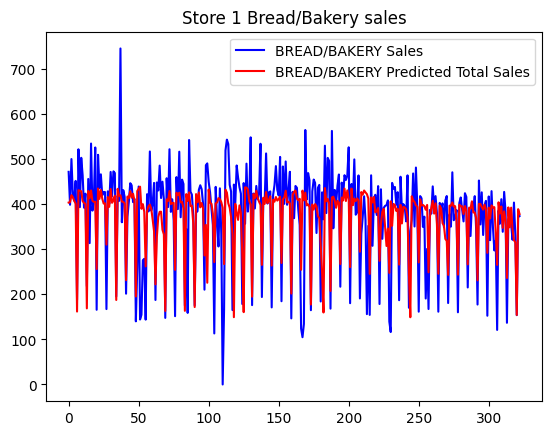

In [12]:
predict_column(6, 100, 32)

Epoch 1/100
42/42 [==============================] - 6s 22ms/step - loss: 4.4951e-04
Epoch 2/100
42/42 [==============================] - 1s 22ms/step - loss: 4.4729e-04
Epoch 3/100
42/42 [==============================] - 1s 22ms/step - loss: 4.5017e-04
Epoch 4/100
42/42 [==============================] - 1s 22ms/step - loss: 4.5010e-04
Epoch 5/100
42/42 [==============================] - 1s 22ms/step - loss: 4.5009e-04
Epoch 6/100
42/42 [==============================] - 1s 22ms/step - loss: 4.5009e-04
Epoch 7/100
42/42 [==============================] - 1s 22ms/step - loss: 4.5009e-04
Epoch 8/100
42/42 [==============================] - 1s 22ms/step - loss: 4.5009e-04
Epoch 9/100
42/42 [==============================] - 1s 22ms/step - loss: 4.5009e-04
Epoch 10/100
42/42 [==============================] - 1s 21ms/step - loss: 4.5009e-04
Epoch 11/100
42/42 [==============================] - 1s 22ms/step - loss: 4.5009e-04
Epoch 12/100
42/42 [==============================] - 1s 22ms/s

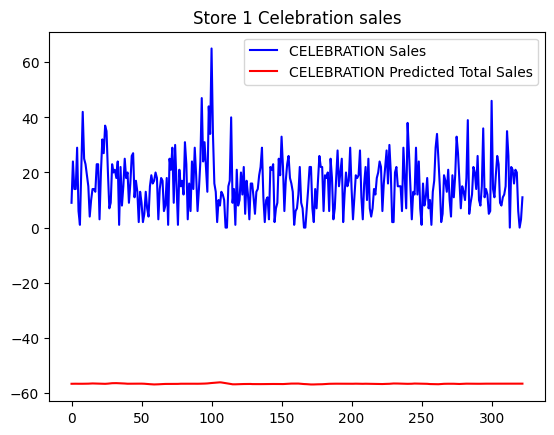

In [13]:
predict_column(7, 100, 32)

Epoch 1/100
42/42 [==============================] - 6s 15ms/step - loss: 0.0201
Epoch 2/100
42/42 [==============================] - 1s 15ms/step - loss: 0.0105
Epoch 3/100
42/42 [==============================] - 1s 15ms/step - loss: 0.0103
Epoch 4/100
42/42 [==============================] - 1s 15ms/step - loss: 0.0106
Epoch 5/100
42/42 [==============================] - 1s 15ms/step - loss: 0.0101
Epoch 6/100
42/42 [==============================] - 1s 15ms/step - loss: 0.0102
Epoch 7/100
42/42 [==============================] - 1s 15ms/step - loss: 0.0103
Epoch 8/100
42/42 [==============================] - 1s 15ms/step - loss: 0.0101
Epoch 9/100
42/42 [==============================] - 1s 15ms/step - loss: 0.0100
Epoch 10/100
42/42 [==============================] - 1s 15ms/step - loss: 0.0101
Epoch 11/100
42/42 [==============================] - 1s 15ms/step - loss: 0.0101
Epoch 12/100
42/42 [==============================] - 1s 15ms/step - loss: 0.0098
Epoch 13/100
42/42 [=====

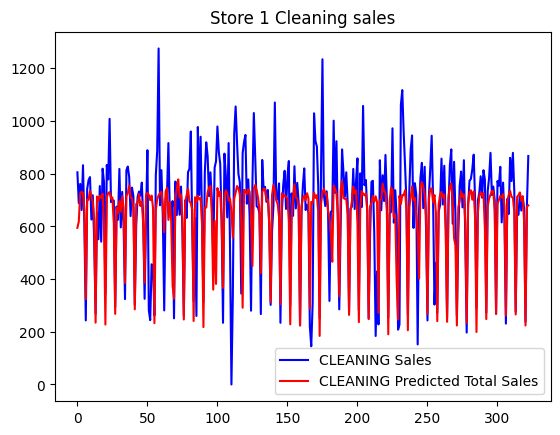

In [14]:
predict_column(8, 100, 32)

Epoch 1/100
42/42 [==============================] - 6s 18ms/step - loss: 0.0283
Epoch 2/100
42/42 [==============================] - 1s 18ms/step - loss: 0.0114
Epoch 3/100
42/42 [==============================] - 1s 18ms/step - loss: 0.0109
Epoch 4/100
42/42 [==============================] - 1s 18ms/step - loss: 0.0109
Epoch 5/100
42/42 [==============================] - 1s 18ms/step - loss: 0.0105
Epoch 6/100
42/42 [==============================] - 1s 18ms/step - loss: 0.0105
Epoch 7/100
42/42 [==============================] - 1s 17ms/step - loss: 0.0103
Epoch 8/100
42/42 [==============================] - 1s 17ms/step - loss: 0.0109
Epoch 9/100
42/42 [==============================] - 1s 17ms/step - loss: 0.0112
Epoch 10/100
42/42 [==============================] - 1s 17ms/step - loss: 0.0108
Epoch 11/100
42/42 [==============================] - 1s 17ms/step - loss: 0.0100
Epoch 12/100
42/42 [==============================] - 1s 17ms/step - loss: 0.0099
Epoch 13/100
42/42 [=====

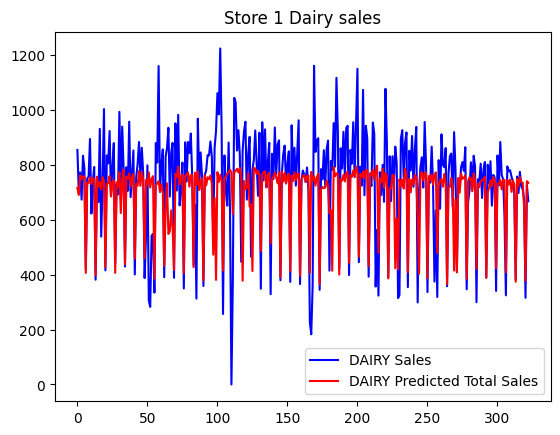

In [15]:
predict_column(9, 100, 32)

Epoch 1/100
42/42 [==============================] - 6s 20ms/step - loss: 0.0254
Epoch 2/100
42/42 [==============================] - 1s 20ms/step - loss: 0.0117
Epoch 3/100
42/42 [==============================] - 1s 20ms/step - loss: 0.0113
Epoch 4/100
42/42 [==============================] - 1s 20ms/step - loss: 0.0108
Epoch 5/100
42/42 [==============================] - 1s 20ms/step - loss: 0.0108
Epoch 6/100
42/42 [==============================] - 1s 20ms/step - loss: 0.0114
Epoch 7/100
42/42 [==============================] - 1s 20ms/step - loss: 0.0112
Epoch 8/100
42/42 [==============================] - 1s 20ms/step - loss: 0.0107
Epoch 9/100
42/42 [==============================] - 1s 20ms/step - loss: 0.0108
Epoch 10/100
42/42 [==============================] - 1s 20ms/step - loss: 0.0107
Epoch 11/100
42/42 [==============================] - 1s 20ms/step - loss: 0.0111
Epoch 12/100
42/42 [==============================] - 1s 19ms/step - loss: 0.0106
Epoch 13/100
42/42 [=====

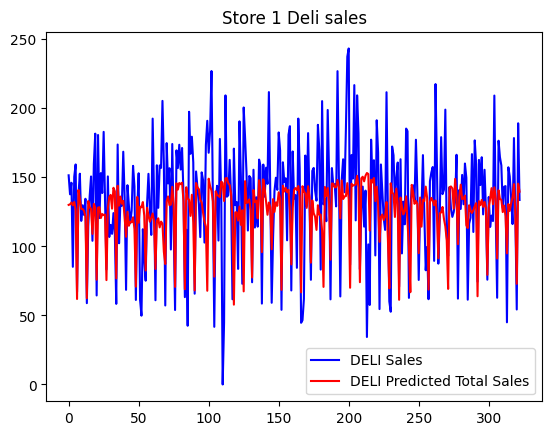

In [16]:
predict_column(10, 100, 32)

Epoch 1/100
42/42 [==============================] - 6s 19ms/step - loss: 0.0308
Epoch 2/100
42/42 [==============================] - 1s 18ms/step - loss: 0.0115
Epoch 3/100
42/42 [==============================] - 1s 18ms/step - loss: 0.0113
Epoch 4/100
42/42 [==============================] - 1s 18ms/step - loss: 0.0116
Epoch 5/100
42/42 [==============================] - 1s 18ms/step - loss: 0.0109
Epoch 6/100
42/42 [==============================] - 1s 18ms/step - loss: 0.0113
Epoch 7/100
42/42 [==============================] - 1s 18ms/step - loss: 0.0113
Epoch 8/100
42/42 [==============================] - 1s 18ms/step - loss: 0.0121
Epoch 9/100
42/42 [==============================] - 1s 18ms/step - loss: 0.0110
Epoch 10/100
42/42 [==============================] - 1s 18ms/step - loss: 0.0111
Epoch 11/100
42/42 [==============================] - 1s 18ms/step - loss: 0.0115
Epoch 12/100
42/42 [==============================] - 1s 18ms/step - loss: 0.0111
Epoch 13/100
42/42 [=====

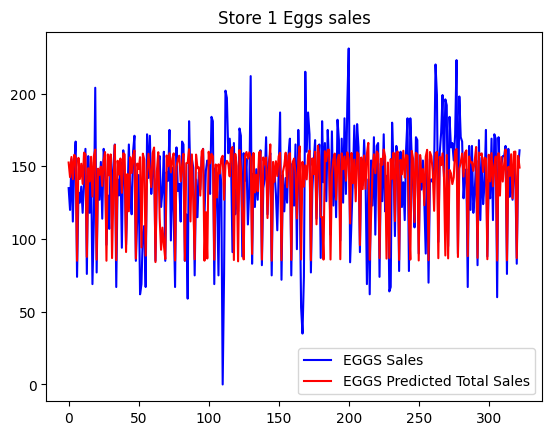

In [17]:
predict_column(11, 100, 32)

Epoch 1/100
42/42 [==============================] - 6s 18ms/step - loss: 6.3179e-04
Epoch 2/100
42/42 [==============================] - 1s 18ms/step - loss: 5.8583e-04
Epoch 3/100
42/42 [==============================] - 1s 18ms/step - loss: 5.8452e-04
Epoch 4/100
42/42 [==============================] - 1s 18ms/step - loss: 5.6471e-04
Epoch 5/100
42/42 [==============================] - 1s 18ms/step - loss: 5.4070e-04
Epoch 6/100
42/42 [==============================] - 1s 18ms/step - loss: 5.4309e-04
Epoch 7/100
42/42 [==============================] - 1s 18ms/step - loss: 5.3493e-04
Epoch 8/100
42/42 [==============================] - 1s 18ms/step - loss: 5.3000e-04
Epoch 9/100
42/42 [==============================] - 1s 18ms/step - loss: 5.8029e-04
Epoch 10/100
42/42 [==============================] - 1s 18ms/step - loss: 5.3812e-04
Epoch 11/100
42/42 [==============================] - 1s 18ms/step - loss: 5.3138e-04
Epoch 12/100
42/42 [==============================] - 1s 18ms/s

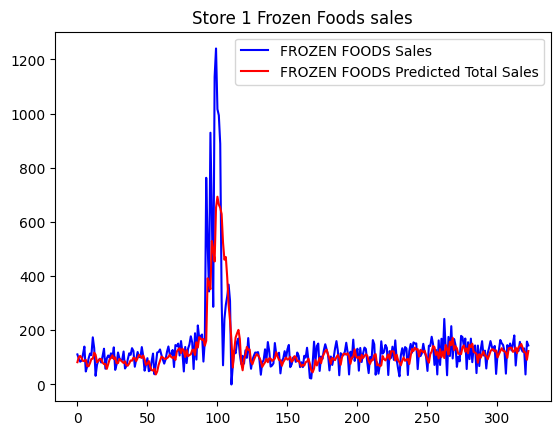

In [18]:
predict_column(12, 100, 32)

Epoch 1/100
42/42 [==============================] - 6s 17ms/step - loss: 0.0081
Epoch 2/100
42/42 [==============================] - 1s 17ms/step - loss: 0.0043
Epoch 3/100
42/42 [==============================] - 1s 17ms/step - loss: 0.0043
Epoch 4/100
42/42 [==============================] - 1s 17ms/step - loss: 0.0042
Epoch 5/100
42/42 [==============================] - 1s 17ms/step - loss: 0.0041
Epoch 6/100
42/42 [==============================] - 1s 17ms/step - loss: 0.0043
Epoch 7/100
42/42 [==============================] - 1s 17ms/step - loss: 0.0043
Epoch 8/100
42/42 [==============================] - 1s 17ms/step - loss: 0.0043
Epoch 9/100
42/42 [==============================] - 1s 17ms/step - loss: 0.0042
Epoch 10/100
42/42 [==============================] - 1s 17ms/step - loss: 0.0042
Epoch 11/100
42/42 [==============================] - 1s 17ms/step - loss: 0.0040
Epoch 12/100
42/42 [==============================] - 1s 17ms/step - loss: 0.0042
Epoch 13/100
42/42 [=====

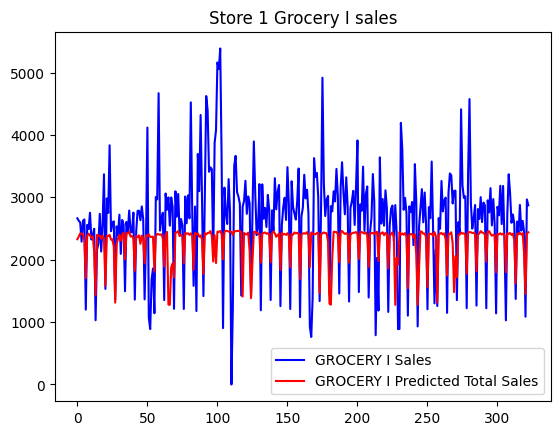

In [19]:
predict_column(13, 100, 32)

Epoch 1/100
42/42 [==============================] - 6s 17ms/step - loss: 0.0074
Epoch 2/100
42/42 [==============================] - 1s 17ms/step - loss: 0.0060
Epoch 3/100
42/42 [==============================] - 1s 17ms/step - loss: 0.0059
Epoch 4/100
42/42 [==============================] - 1s 18ms/step - loss: 0.0059
Epoch 5/100
42/42 [==============================] - 1s 17ms/step - loss: 0.0059
Epoch 6/100
42/42 [==============================] - 1s 17ms/step - loss: 0.0061
Epoch 7/100
42/42 [==============================] - 1s 17ms/step - loss: 0.0060
Epoch 8/100
42/42 [==============================] - 1s 17ms/step - loss: 0.0059
Epoch 9/100
42/42 [==============================] - 1s 17ms/step - loss: 0.0060
Epoch 10/100
42/42 [==============================] - 1s 18ms/step - loss: 0.0059
Epoch 11/100
42/42 [==============================] - 1s 16ms/step - loss: 0.0059
Epoch 12/100
42/42 [==============================] - 1s 18ms/step - loss: 0.0060
Epoch 13/100
42/42 [=====

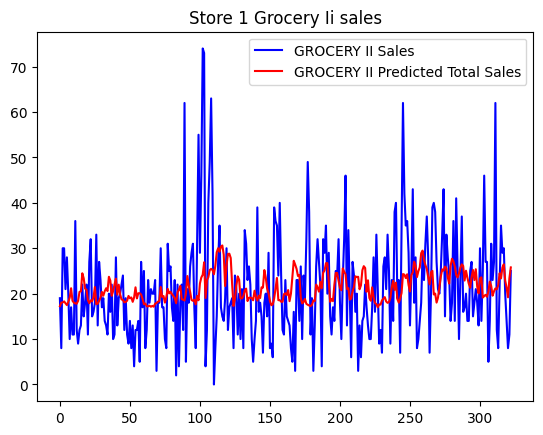

In [20]:
predict_column(14, 100, 32)

Epoch 1/100
42/42 [==============================] - 6s 21ms/step - loss: 0.0121
Epoch 2/100
42/42 [==============================] - 1s 21ms/step - loss: 0.0115
Epoch 3/100
42/42 [==============================] - 1s 22ms/step - loss: 0.0115
Epoch 4/100
42/42 [==============================] - 1s 21ms/step - loss: 0.0116
Epoch 5/100
42/42 [==============================] - 1s 21ms/step - loss: 0.0115
Epoch 6/100
42/42 [==============================] - 1s 22ms/step - loss: 0.0115
Epoch 7/100
42/42 [==============================] - 1s 22ms/step - loss: 0.0114
Epoch 8/100
42/42 [==============================] - 1s 22ms/step - loss: 0.0116
Epoch 9/100
42/42 [==============================] - 1s 21ms/step - loss: 0.0114
Epoch 10/100
42/42 [==============================] - 1s 21ms/step - loss: 0.0116
Epoch 11/100
42/42 [==============================] - 1s 22ms/step - loss: 0.0114
Epoch 12/100
42/42 [==============================] - 1s 21ms/step - loss: 0.0115
Epoch 13/100
42/42 [=====

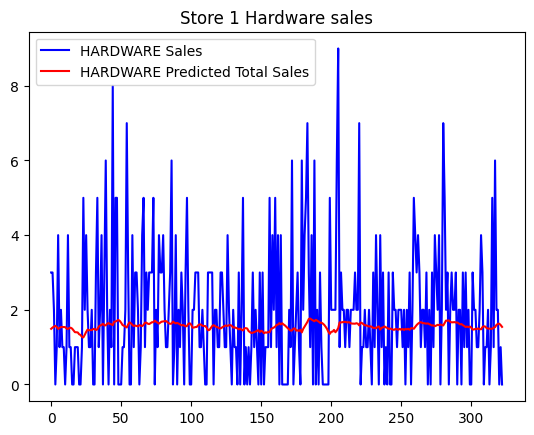

In [21]:
predict_column(15, 100, 32)

Epoch 1/100
42/42 [==============================] - 6s 20ms/step - loss: 9.2496e-04
Epoch 2/100
42/42 [==============================] - 1s 20ms/step - loss: 8.3237e-04
Epoch 3/100
42/42 [==============================] - 1s 20ms/step - loss: 7.9781e-04
Epoch 4/100
42/42 [==============================] - 1s 20ms/step - loss: 7.8538e-04
Epoch 5/100
42/42 [==============================] - 1s 20ms/step - loss: 7.8860e-04
Epoch 6/100
42/42 [==============================] - 1s 20ms/step - loss: 7.8930e-04
Epoch 7/100
42/42 [==============================] - 1s 20ms/step - loss: 7.7450e-04
Epoch 8/100
42/42 [==============================] - 1s 19ms/step - loss: 7.7840e-04
Epoch 9/100
42/42 [==============================] - 1s 20ms/step - loss: 8.0192e-04
Epoch 10/100
42/42 [==============================] - 1s 19ms/step - loss: 7.6403e-04
Epoch 11/100
42/42 [==============================] - 1s 20ms/step - loss: 7.6088e-04
Epoch 12/100
42/42 [==============================] - 1s 20ms/s

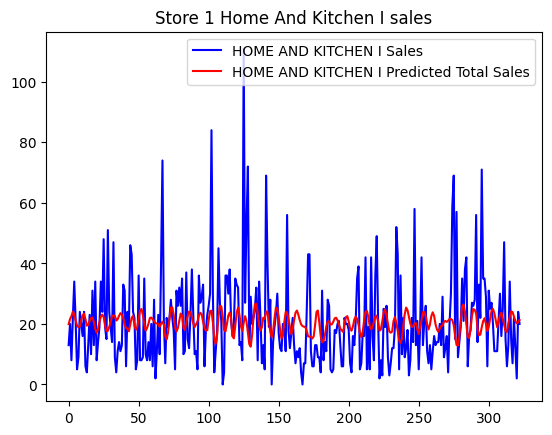

In [22]:
predict_column(16, 100, 32)

Epoch 1/100
42/42 [==============================] - 6s 18ms/step - loss: 0.0022
Epoch 2/100
42/42 [==============================] - 1s 18ms/step - loss: 0.0019
Epoch 3/100
42/42 [==============================] - 1s 18ms/step - loss: 0.0019
Epoch 4/100
42/42 [==============================] - 1s 19ms/step - loss: 0.0019
Epoch 5/100
42/42 [==============================] - 1s 19ms/step - loss: 0.0018
Epoch 6/100
42/42 [==============================] - 1s 18ms/step - loss: 0.0019
Epoch 7/100
42/42 [==============================] - 1s 18ms/step - loss: 0.0018
Epoch 8/100
42/42 [==============================] - 1s 18ms/step - loss: 0.0018
Epoch 9/100
42/42 [==============================] - 1s 18ms/step - loss: 0.0018
Epoch 10/100
42/42 [==============================] - 1s 18ms/step - loss: 0.0017
Epoch 11/100
42/42 [==============================] - 1s 18ms/step - loss: 0.0018
Epoch 12/100
42/42 [==============================] - 1s 18ms/step - loss: 0.0017
Epoch 13/100
42/42 [=====

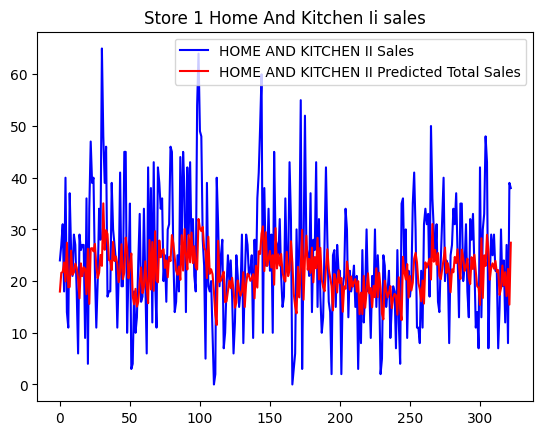

In [23]:
predict_column(17, 100, 32)

Epoch 1/100
42/42 [==============================] - 6s 19ms/step - loss: 0.0118
Epoch 2/100
42/42 [==============================] - 1s 19ms/step - loss: 0.0118
Epoch 3/100
42/42 [==============================] - 1s 19ms/step - loss: 0.0118
Epoch 4/100
42/42 [==============================] - 1s 19ms/step - loss: 0.0118
Epoch 5/100
42/42 [==============================] - 1s 19ms/step - loss: 0.0118
Epoch 6/100
42/42 [==============================] - 1s 19ms/step - loss: 0.0118
Epoch 7/100
42/42 [==============================] - 1s 19ms/step - loss: 0.0118
Epoch 8/100
42/42 [==============================] - 1s 19ms/step - loss: 0.0118
Epoch 9/100
42/42 [==============================] - 1s 19ms/step - loss: 0.0118
Epoch 10/100
42/42 [==============================] - 1s 19ms/step - loss: 0.0118
Epoch 11/100
42/42 [==============================] - 1s 19ms/step - loss: 0.0118
Epoch 12/100
42/42 [==============================] - 1s 19ms/step - loss: 0.0118
Epoch 13/100
42/42 [=====

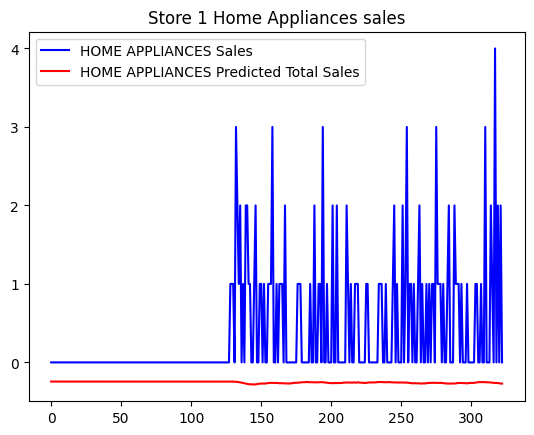

In [24]:
predict_column(18, 100, 32)

Epoch 1/100
42/42 [==============================] - 6s 20ms/step - loss: 0.0062
Epoch 2/100
42/42 [==============================] - 1s 20ms/step - loss: 0.0034
Epoch 3/100
42/42 [==============================] - 1s 20ms/step - loss: 0.0032
Epoch 4/100
42/42 [==============================] - 1s 20ms/step - loss: 0.0031
Epoch 5/100
42/42 [==============================] - 1s 20ms/step - loss: 0.0030
Epoch 6/100
42/42 [==============================] - 1s 20ms/step - loss: 0.0030
Epoch 7/100
42/42 [==============================] - 1s 20ms/step - loss: 0.0029
Epoch 8/100
42/42 [==============================] - 1s 20ms/step - loss: 0.0028
Epoch 9/100
42/42 [==============================] - 1s 20ms/step - loss: 0.0027
Epoch 10/100
42/42 [==============================] - 1s 20ms/step - loss: 0.0026
Epoch 11/100
42/42 [==============================] - 1s 20ms/step - loss: 0.0025
Epoch 12/100
42/42 [==============================] - 1s 20ms/step - loss: 0.0023
Epoch 13/100
42/42 [=====

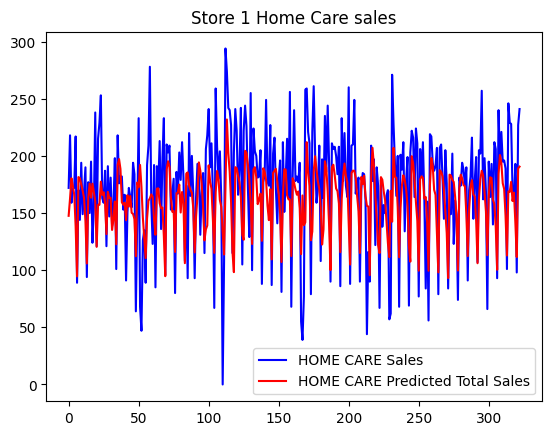

In [25]:
predict_column(19, 100, 32)

Epoch 1/100
42/42 [==============================] - 6s 19ms/step - loss: 0.0160
Epoch 2/100
42/42 [==============================] - 1s 18ms/step - loss: 0.0121
Epoch 3/100
42/42 [==============================] - 1s 18ms/step - loss: 0.0111
Epoch 4/100
42/42 [==============================] - 1s 18ms/step - loss: 0.0101
Epoch 5/100
42/42 [==============================] - 1s 19ms/step - loss: 0.0100
Epoch 6/100
42/42 [==============================] - 1s 18ms/step - loss: 0.0104
Epoch 7/100
42/42 [==============================] - 1s 18ms/step - loss: 0.0093
Epoch 8/100
42/42 [==============================] - 1s 18ms/step - loss: 0.0094
Epoch 9/100
42/42 [==============================] - 1s 18ms/step - loss: 0.0092
Epoch 10/100
42/42 [==============================] - 1s 18ms/step - loss: 0.0090
Epoch 11/100
42/42 [==============================] - 1s 18ms/step - loss: 0.0091
Epoch 12/100
42/42 [==============================] - 1s 18ms/step - loss: 0.0089
Epoch 13/100
42/42 [=====

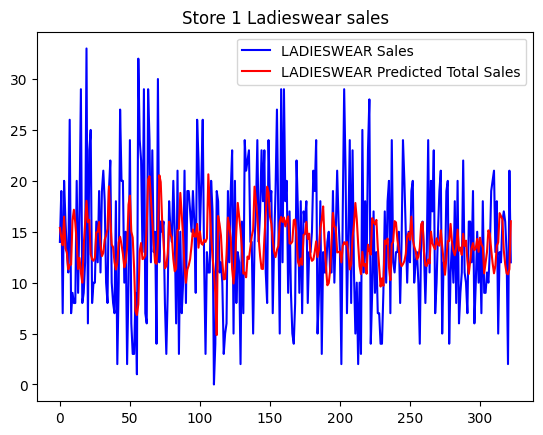

In [26]:
predict_column(20, 100, 32)

Epoch 1/100
42/42 [==============================] - 6s 20ms/step - loss: 0.0177
Epoch 2/100
42/42 [==============================] - 1s 20ms/step - loss: 0.0144
Epoch 3/100
42/42 [==============================] - 1s 20ms/step - loss: 0.0139
Epoch 4/100
42/42 [==============================] - 1s 20ms/step - loss: 0.0139
Epoch 5/100
42/42 [==============================] - 1s 20ms/step - loss: 0.0141
Epoch 6/100
42/42 [==============================] - 1s 20ms/step - loss: 0.0136
Epoch 7/100
42/42 [==============================] - 1s 19ms/step - loss: 0.0139
Epoch 8/100
42/42 [==============================] - 1s 19ms/step - loss: 0.0138
Epoch 9/100
42/42 [==============================] - 1s 19ms/step - loss: 0.0141
Epoch 10/100
42/42 [==============================] - 1s 20ms/step - loss: 0.0139
Epoch 11/100
42/42 [==============================] - 1s 19ms/step - loss: 0.0135
Epoch 12/100
42/42 [==============================] - 1s 19ms/step - loss: 0.0139
Epoch 13/100
42/42 [=====

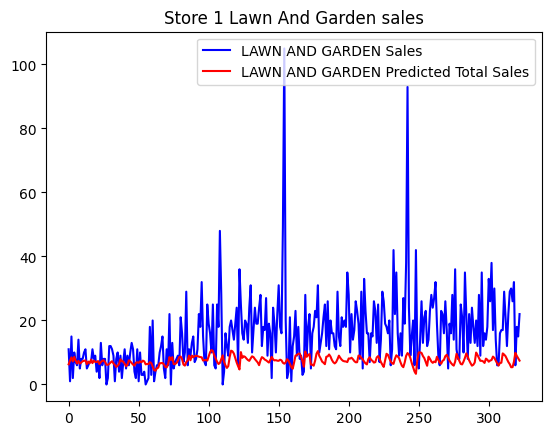

In [27]:
predict_column(21, 100, 32)

Epoch 1/100
42/42 [==============================] - 6s 18ms/step - loss: 0.0106
Epoch 2/100
42/42 [==============================] - 1s 18ms/step - loss: 0.0095
Epoch 3/100
42/42 [==============================] - 1s 18ms/step - loss: 0.0094
Epoch 4/100
42/42 [==============================] - 1s 18ms/step - loss: 0.0093
Epoch 5/100
42/42 [==============================] - 1s 18ms/step - loss: 0.0092
Epoch 6/100
42/42 [==============================] - 1s 18ms/step - loss: 0.0091
Epoch 7/100
42/42 [==============================] - 1s 18ms/step - loss: 0.0091
Epoch 8/100
42/42 [==============================] - 1s 18ms/step - loss: 0.0091
Epoch 9/100
42/42 [==============================] - 1s 18ms/step - loss: 0.0091
Epoch 10/100
42/42 [==============================] - 1s 18ms/step - loss: 0.0092
Epoch 11/100
42/42 [==============================] - 1s 18ms/step - loss: 0.0091
Epoch 12/100
42/42 [==============================] - 1s 18ms/step - loss: 0.0090
Epoch 13/100
42/42 [=====

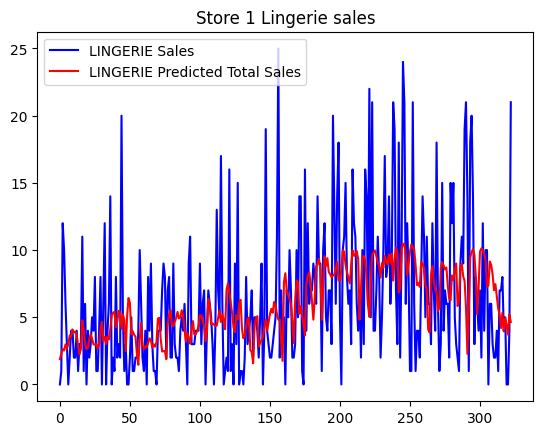

In [28]:
predict_column(22, 100, 32)

Epoch 1/100
42/42 [==============================] - 6s 18ms/step - loss: 0.0110
Epoch 2/100
42/42 [==============================] - 1s 18ms/step - loss: 0.0090
Epoch 3/100
42/42 [==============================] - 1s 18ms/step - loss: 0.0088
Epoch 4/100
42/42 [==============================] - 1s 18ms/step - loss: 0.0083
Epoch 5/100
42/42 [==============================] - 1s 18ms/step - loss: 0.0081
Epoch 6/100
42/42 [==============================] - 1s 18ms/step - loss: 0.0070
Epoch 7/100
42/42 [==============================] - 1s 18ms/step - loss: 0.0066
Epoch 8/100
42/42 [==============================] - 1s 18ms/step - loss: 0.0063
Epoch 9/100
42/42 [==============================] - 1s 18ms/step - loss: 0.0064
Epoch 10/100
42/42 [==============================] - 1s 18ms/step - loss: 0.0059
Epoch 11/100
42/42 [==============================] - 1s 18ms/step - loss: 0.0059
Epoch 12/100
42/42 [==============================] - 1s 18ms/step - loss: 0.0059
Epoch 13/100
42/42 [=====

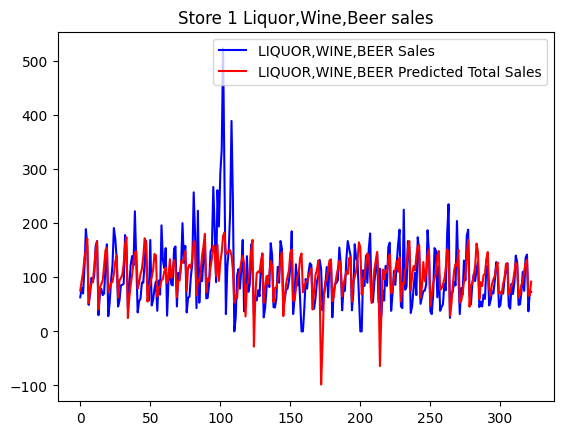

In [29]:
predict_column(23, 100, 32)

Epoch 1/100
42/42 [==============================] - 6s 19ms/step - loss: 0.0165
Epoch 2/100
42/42 [==============================] - 1s 19ms/step - loss: 0.0100
Epoch 3/100
42/42 [==============================] - 1s 18ms/step - loss: 0.0095
Epoch 4/100
42/42 [==============================] - 1s 19ms/step - loss: 0.0095
Epoch 5/100
42/42 [==============================] - 1s 19ms/step - loss: 0.0097
Epoch 6/100
42/42 [==============================] - 1s 19ms/step - loss: 0.0094
Epoch 7/100
42/42 [==============================] - 1s 19ms/step - loss: 0.0095
Epoch 8/100
42/42 [==============================] - 1s 20ms/step - loss: 0.0092
Epoch 9/100
42/42 [==============================] - 1s 19ms/step - loss: 0.0092
Epoch 10/100
42/42 [==============================] - 1s 19ms/step - loss: 0.0090
Epoch 11/100
42/42 [==============================] - 1s 19ms/step - loss: 0.0091
Epoch 12/100
42/42 [==============================] - 1s 19ms/step - loss: 0.0091
Epoch 13/100
42/42 [=====

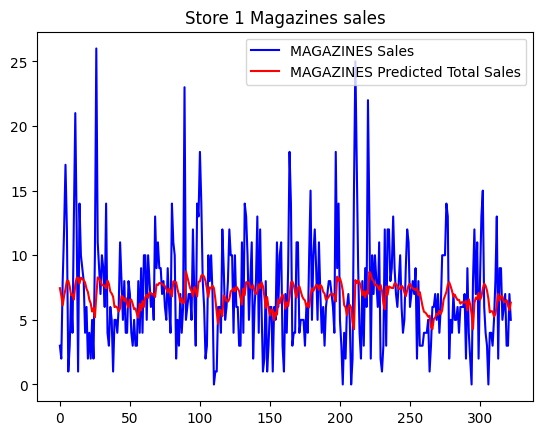

In [30]:
predict_column(24, 100, 32)

Epoch 1/100
42/42 [==============================] - 6s 20ms/step - loss: 0.0154
Epoch 2/100
42/42 [==============================] - 1s 20ms/step - loss: 0.0118
Epoch 3/100
42/42 [==============================] - 1s 20ms/step - loss: 0.0117
Epoch 4/100
42/42 [==============================] - 1s 20ms/step - loss: 0.0117
Epoch 5/100
42/42 [==============================] - 1s 20ms/step - loss: 0.0112
Epoch 6/100
42/42 [==============================] - 1s 21ms/step - loss: 0.0103
Epoch 7/100
42/42 [==============================] - 1s 21ms/step - loss: 0.0104
Epoch 8/100
42/42 [==============================] - 1s 20ms/step - loss: 0.0096
Epoch 9/100
42/42 [==============================] - 1s 20ms/step - loss: 0.0090
Epoch 10/100
42/42 [==============================] - 1s 20ms/step - loss: 0.0085
Epoch 11/100
42/42 [==============================] - 1s 20ms/step - loss: 0.0086
Epoch 12/100
42/42 [==============================] - 1s 20ms/step - loss: 0.0087
Epoch 13/100
42/42 [=====

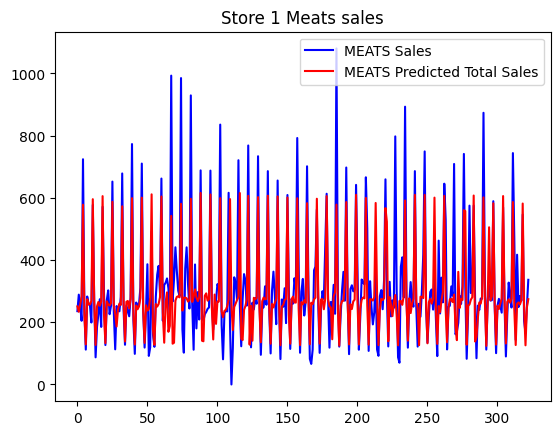

In [31]:
predict_column(25, 100, 32)

Epoch 1/100
42/42 [==============================] - 6s 20ms/step - loss: 0.0049
Epoch 2/100
42/42 [==============================] - 1s 20ms/step - loss: 0.0031
Epoch 3/100
42/42 [==============================] - 1s 20ms/step - loss: 0.0030
Epoch 4/100
42/42 [==============================] - 1s 20ms/step - loss: 0.0028
Epoch 5/100
42/42 [==============================] - 1s 20ms/step - loss: 0.0030
Epoch 6/100
42/42 [==============================] - 1s 20ms/step - loss: 0.0029
Epoch 7/100
42/42 [==============================] - 1s 20ms/step - loss: 0.0028
Epoch 8/100
42/42 [==============================] - 1s 19ms/step - loss: 0.0028
Epoch 9/100
42/42 [==============================] - 1s 20ms/step - loss: 0.0028
Epoch 10/100
42/42 [==============================] - 1s 20ms/step - loss: 0.0028
Epoch 11/100
42/42 [==============================] - 1s 20ms/step - loss: 0.0029
Epoch 12/100
42/42 [==============================] - 1s 20ms/step - loss: 0.0028
Epoch 13/100
42/42 [=====

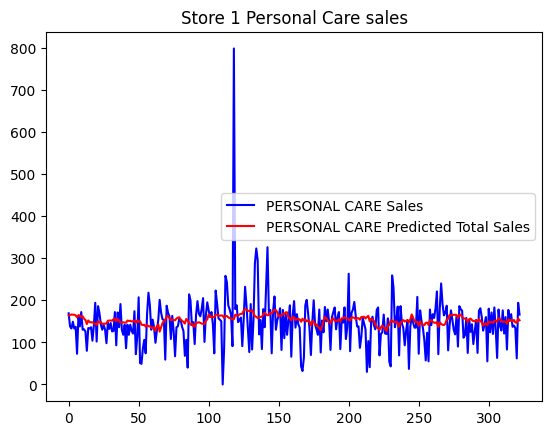

In [32]:
predict_column(26, 100, 32)

Epoch 1/100
42/42 [==============================] - 6s 22ms/step - loss: 0.0117
Epoch 2/100
42/42 [==============================] - 1s 22ms/step - loss: 0.0100
Epoch 3/100
42/42 [==============================] - 1s 22ms/step - loss: 0.0097
Epoch 4/100
42/42 [==============================] - 1s 22ms/step - loss: 0.0097
Epoch 5/100
42/42 [==============================] - 1s 22ms/step - loss: 0.0093
Epoch 6/100
42/42 [==============================] - 1s 22ms/step - loss: 0.0092
Epoch 7/100
42/42 [==============================] - 1s 22ms/step - loss: 0.0090
Epoch 8/100
42/42 [==============================] - 1s 22ms/step - loss: 0.0090
Epoch 9/100
42/42 [==============================] - 1s 22ms/step - loss: 0.0088
Epoch 10/100
42/42 [==============================] - 1s 22ms/step - loss: 0.0088
Epoch 11/100
42/42 [==============================] - 1s 22ms/step - loss: 0.0090
Epoch 12/100
42/42 [==============================] - 1s 22ms/step - loss: 0.0086
Epoch 13/100
42/42 [=====

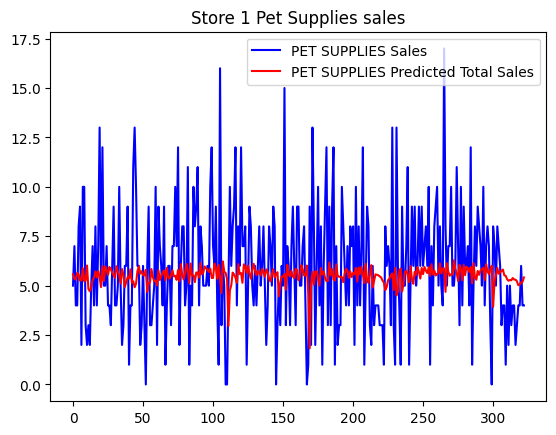

In [33]:
predict_column(27, 100, 32)

Epoch 1/100
42/42 [==============================] - 6s 21ms/step - loss: 0.0072
Epoch 2/100
42/42 [==============================] - 1s 21ms/step - loss: 0.0057
Epoch 3/100
42/42 [==============================] - 1s 21ms/step - loss: 0.0057
Epoch 4/100
42/42 [==============================] - 1s 21ms/step - loss: 0.0057
Epoch 5/100
42/42 [==============================] - 1s 21ms/step - loss: 0.0056
Epoch 6/100
42/42 [==============================] - 1s 21ms/step - loss: 0.0056
Epoch 7/100
42/42 [==============================] - 1s 21ms/step - loss: 0.0055
Epoch 8/100
42/42 [==============================] - 1s 21ms/step - loss: 0.0055
Epoch 9/100
42/42 [==============================] - 1s 21ms/step - loss: 0.0054
Epoch 10/100
42/42 [==============================] - 1s 21ms/step - loss: 0.0056
Epoch 11/100
42/42 [==============================] - 1s 21ms/step - loss: 0.0055
Epoch 12/100
42/42 [==============================] - 1s 21ms/step - loss: 0.0054
Epoch 13/100
42/42 [=====

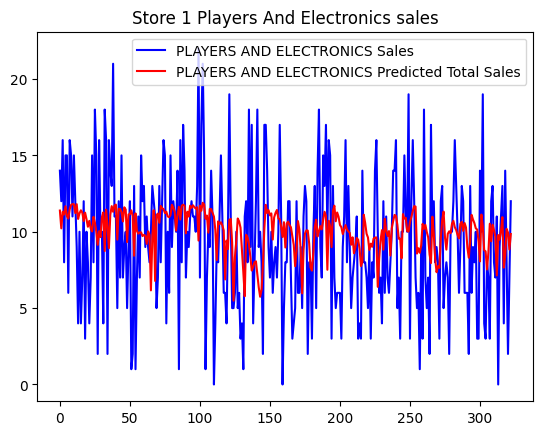

In [34]:
predict_column(28, 100, 32)

Epoch 1/100
42/42 [==============================] - 6s 19ms/step - loss: 0.0825
Epoch 2/100
42/42 [==============================] - 1s 19ms/step - loss: 0.0795
Epoch 3/100
42/42 [==============================] - 1s 19ms/step - loss: 0.0117
Epoch 4/100
42/42 [==============================] - 1s 19ms/step - loss: 0.0092
Epoch 5/100
42/42 [==============================] - 1s 19ms/step - loss: 0.0092
Epoch 6/100
42/42 [==============================] - 1s 19ms/step - loss: 0.0097
Epoch 7/100
42/42 [==============================] - 1s 19ms/step - loss: 0.0090
Epoch 8/100
42/42 [==============================] - 1s 19ms/step - loss: 0.0091
Epoch 9/100
42/42 [==============================] - 1s 19ms/step - loss: 0.0085
Epoch 10/100
42/42 [==============================] - 1s 19ms/step - loss: 0.0082
Epoch 11/100
42/42 [==============================] - 1s 19ms/step - loss: 0.0082
Epoch 12/100
42/42 [==============================] - 1s 19ms/step - loss: 0.0079
Epoch 13/100
42/42 [=====

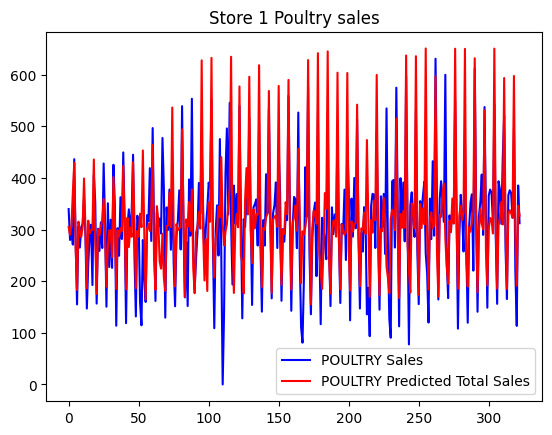

In [35]:
predict_column(29, 100, 32)

Epoch 1/100
42/42 [==============================] - 6s 19ms/step - loss: 0.0197
Epoch 2/100
42/42 [==============================] - 1s 19ms/step - loss: 0.0078
Epoch 3/100
42/42 [==============================] - 1s 19ms/step - loss: 0.0077
Epoch 4/100
42/42 [==============================] - 1s 19ms/step - loss: 0.0075
Epoch 5/100
42/42 [==============================] - 1s 19ms/step - loss: 0.0075
Epoch 6/100
42/42 [==============================] - 1s 19ms/step - loss: 0.0073
Epoch 7/100
42/42 [==============================] - 1s 19ms/step - loss: 0.0071
Epoch 8/100
42/42 [==============================] - 1s 19ms/step - loss: 0.0073
Epoch 9/100
42/42 [==============================] - 1s 19ms/step - loss: 0.0075
Epoch 10/100
42/42 [==============================] - 1s 19ms/step - loss: 0.0073
Epoch 11/100
42/42 [==============================] - 1s 19ms/step - loss: 0.0071
Epoch 12/100
42/42 [==============================] - 1s 19ms/step - loss: 0.0074
Epoch 13/100
42/42 [=====

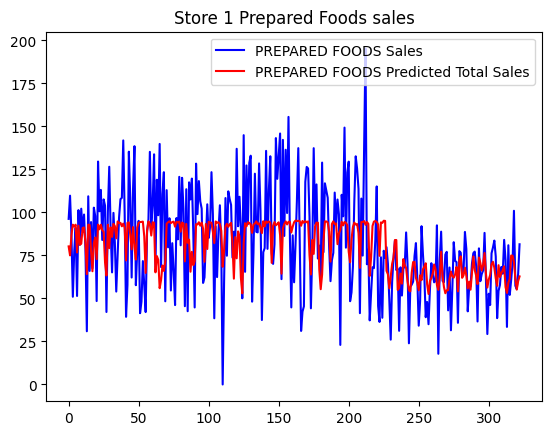

In [36]:
predict_column(30, 100, 32)

Epoch 1/100
42/42 [==============================] - 6s 22ms/step - loss: 0.0230
Epoch 2/100
42/42 [==============================] - 1s 21ms/step - loss: 0.0138
Epoch 3/100
42/42 [==============================] - 1s 21ms/step - loss: 0.0146
Epoch 4/100
42/42 [==============================] - 1s 21ms/step - loss: 0.0142
Epoch 5/100
42/42 [==============================] - 1s 21ms/step - loss: 0.0132
Epoch 6/100
42/42 [==============================] - 1s 21ms/step - loss: 0.0130
Epoch 7/100
42/42 [==============================] - 1s 21ms/step - loss: 0.0123
Epoch 8/100
42/42 [==============================] - 1s 21ms/step - loss: 0.0123
Epoch 9/100
42/42 [==============================] - 1s 21ms/step - loss: 0.0123
Epoch 10/100
42/42 [==============================] - 1s 21ms/step - loss: 0.0116
Epoch 11/100
42/42 [==============================] - 1s 21ms/step - loss: 0.0117
Epoch 12/100
42/42 [==============================] - 1s 21ms/step - loss: 0.0121
Epoch 13/100
42/42 [=====

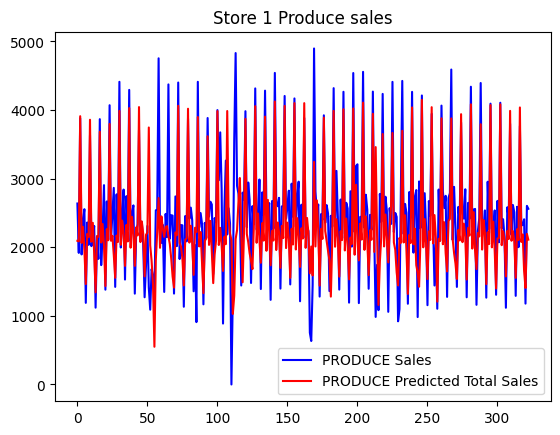

In [37]:
predict_column(31, 100, 32)

Epoch 1/100
42/42 [==============================] - 6s 20ms/step - loss: 0.0068
Epoch 2/100
42/42 [==============================] - 1s 20ms/step - loss: 0.0062
Epoch 3/100
42/42 [==============================] - 1s 20ms/step - loss: 0.0063
Epoch 4/100
42/42 [==============================] - 1s 20ms/step - loss: 0.0063
Epoch 5/100
42/42 [==============================] - 1s 20ms/step - loss: 0.0061
Epoch 6/100
42/42 [==============================] - 1s 20ms/step - loss: 0.0062
Epoch 7/100
42/42 [==============================] - 1s 20ms/step - loss: 0.0061
Epoch 8/100
42/42 [==============================] - 1s 20ms/step - loss: 0.0062
Epoch 9/100
42/42 [==============================] - 1s 20ms/step - loss: 0.0062
Epoch 10/100
42/42 [==============================] - 1s 20ms/step - loss: 0.0061
Epoch 11/100
42/42 [==============================] - 1s 20ms/step - loss: 0.0060
Epoch 12/100
42/42 [==============================] - 1s 20ms/step - loss: 0.0063
Epoch 13/100
42/42 [=====

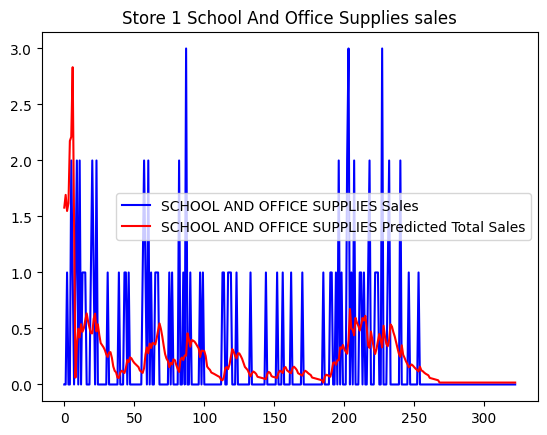

In [38]:
predict_column(32, 100, 32)

Epoch 1/100
42/42 [==============================] - 6s 20ms/step - loss: 0.0143
Epoch 2/100
42/42 [==============================] - 1s 20ms/step - loss: 0.0091
Epoch 3/100
42/42 [==============================] - 1s 20ms/step - loss: 0.0091
Epoch 4/100
42/42 [==============================] - 1s 21ms/step - loss: 0.0090
Epoch 5/100
42/42 [==============================] - 1s 21ms/step - loss: 0.0099
Epoch 6/100
42/42 [==============================] - 1s 20ms/step - loss: 0.0092
Epoch 7/100
42/42 [==============================] - 1s 20ms/step - loss: 0.0091
Epoch 8/100
42/42 [==============================] - 1s 20ms/step - loss: 0.0089
Epoch 9/100
42/42 [==============================] - 1s 20ms/step - loss: 0.0089
Epoch 10/100
42/42 [==============================] - 1s 20ms/step - loss: 0.0091
Epoch 11/100
42/42 [==============================] - 1s 20ms/step - loss: 0.0088
Epoch 12/100
42/42 [==============================] - 1s 21ms/step - loss: 0.0088
Epoch 13/100
42/42 [=====

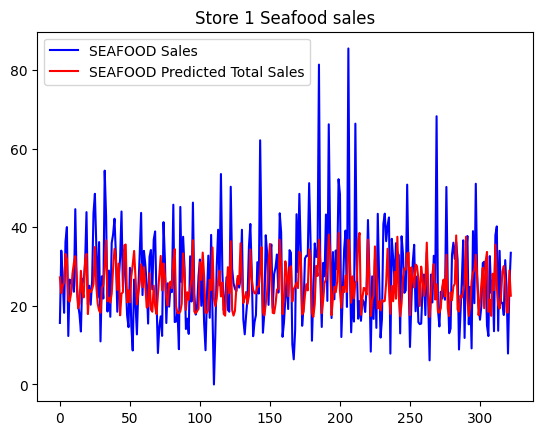

In [39]:
predict_column(33, 100, 32)

Epoch 1/100
42/42 [==============================] - 6s 20ms/step - loss: 0.0176
Epoch 2/100
42/42 [==============================] - 1s 20ms/step - loss: 0.0082
Epoch 3/100
42/42 [==============================] - 1s 20ms/step - loss: 0.0081
Epoch 4/100
42/42 [==============================] - 1s 20ms/step - loss: 0.0080
Epoch 5/100
42/42 [==============================] - 1s 20ms/step - loss: 0.0077
Epoch 6/100
42/42 [==============================] - 1s 20ms/step - loss: 0.0077
Epoch 7/100
42/42 [==============================] - 1s 20ms/step - loss: 0.0078
Epoch 8/100
42/42 [==============================] - 1s 20ms/step - loss: 0.0077
Epoch 9/100
42/42 [==============================] - 1s 20ms/step - loss: 0.0075
Epoch 10/100
42/42 [==============================] - 1s 20ms/step - loss: 0.0075
Epoch 11/100
42/42 [==============================] - 1s 20ms/step - loss: 0.0076
Epoch 12/100
42/42 [==============================] - 1s 20ms/step - loss: 0.0076
Epoch 13/100
42/42 [=====

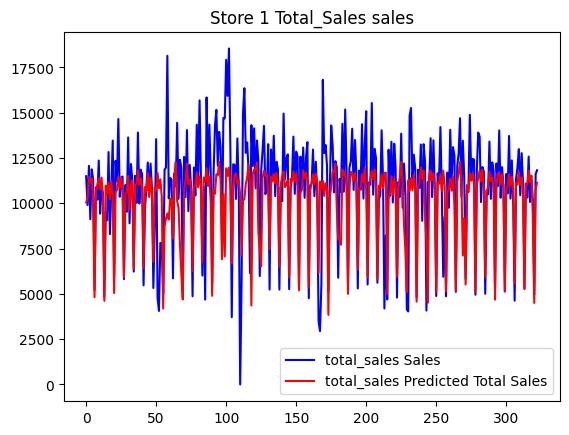

In [40]:
predict_column(34, 100, 32)